# Actividad 3: Detección de anomalías y Técnicas de Agrupamiento

<center><b> Equipo 2: </b></center>  
<center><b> Alicia Amores Sánchez </b></center> 
<center><b> Eduardo Reyero Ibáñez </b></center>
<center><b> Gerard Vazquez Rubio </b></center>
<center><b> Javier Fernandez Lasso </b></center>

<img src="tabla_trabajo.png">

## 1. Importar datos

In [1]:
# Librerias
import pandas as pd
import numpy as np
import missingno
%matplotlib inline 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import itertools
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
# Importar dataset
creditCard_df = pd.read_csv('creditcardcsvpresent.csv')
print('Dimensiones del dataset: {}'.format(creditCard_df.shape))
print ('Observamos las primeras lineas:')
creditCard_df.head()

Dimensiones del dataset: (3075, 12)
Observamos las primeras lineas:


,Merchant_id,Transaction date,Average Amount/transaction/day,Transaction_amount,Is declined,Total Number of declines/day,isForeignTransaction,isHighRiskCountry,Daily_chargeback_avg_amt,6_month_avg_chbk_amt,6-month_chbk_freq,isFradulent
0,3160040998,NaN,100.0,3000.0,N,5,Y,Y,0,0.0,0,Y
1,3160040998,NaN,100.0,4300.0,N,5,Y,Y,0,0.0,0,Y
2,3160041896,NaN,185.5,4823.0,Y,5,N,N,0,0.0,0,Y
3,3160141996,NaN,185.5,5008.5,Y,8,N,N,0,0.0,0,Y
4,3160241992,NaN,500.0,26000.0,N,0,Y,Y,800,677.2,6,Y


## 2. Análisis descriptivo de los datos

### 2.1 Variables numéricas

In [3]:
# Obtener num de elementos, media, desv típica, max, min y cuartiles
# Quitamos el ID y fechas para mostrar las estadisticas numéricas
creditCard_df2 = pd.DataFrame(creditCard_df[creditCard_df.columns[2:]])

stats_df = creditCard_df2.describe()
# Obtener y añadir la mediana
median = pd.DataFrame(creditCard_df2.median())
median = median.transpose()
median.rename(index = {0:'median'},inplace = True)
stats_df = stats_df.append(median).transpose() 
stats_df

,count,mean,std,min,25%,50%,75%,max,median
Average Amount/transaction/day,3075.0,515.026556,291.906978,4.011527,269.788047,502.549575,765.272803,2000.0,502.549575
Transaction_amount,3075.0,9876.399210,10135.331016,0.000000,2408.781147,6698.891856,14422.568935,108000.0,6698.891856
Total Number of declines/day,3075.0,0.957398,2.192391,0.000000,0.000000,0.000000,0.000000,20.0,0.000000
Daily_chargeback_avg_amt,3075.0,55.737561,206.634779,0.000000,0.000000,0.000000,0.000000,998.0,0.000000
6_month_avg_chbk_amt,3075.0,40.022407,155.968840,0.000000,0.000000,0.000000,0.000000,998.0,0.000000
6-month_chbk_freq,3075.0,0.391870,1.548479,0.000000,0.000000,0.000000,0.000000,9.0,0.000000


### 2.2 Variables categóricas

In [4]:
creditCard_df.describe(include='object').T

,count,unique,top,freq
Is declined,3075,2,N,3018
isForeignTransaction,3075,2,N,2369
isHighRiskCountry,3075,2,N,2870
isFradulent,3075,2,N,2627


In [5]:
for column in creditCard_df.select_dtypes(include='object').columns:
    print(creditCard_df[column].value_counts())
    print('-'*20)

N    3018
Y      57
Name: Is declined, dtype: int64
--------------------
N    2369
Y     706
Name: isForeignTransaction, dtype: int64
--------------------
N    2870
Y     205
Name: isHighRiskCountry, dtype: int64
--------------------
N    2627
Y     448
Name: isFradulent, dtype: int64
--------------------


### 2.3 Matriz de correlaciones y análisis de los resultados

In [6]:
# El ID y la fecha no los incluyo
var_num = creditCard_df2.select_dtypes(include = ['int64','float64']).reset_index(drop = True)
corr_mat = var_num.corr()
corr_mat

,Average Amount/transaction/day,Transaction_amount,Total Number of declines/day,Daily_chargeback_avg_amt,6_month_avg_chbk_amt,6-month_chbk_freq
Average Amount/transaction/day,1.000000,0.587111,-0.009682,0.060429,0.060284,0.071849
Transaction_amount,0.587111,1.000000,0.259309,0.252298,0.259663,0.297623
Total Number of declines/day,-0.009682,0.259309,1.000000,0.094834,0.081138,0.085028
Daily_chargeback_avg_amt,0.060429,0.252298,0.094834,1.000000,0.953663,0.884611
6_month_avg_chbk_amt,0.060284,0.259663,0.081138,0.953663,1.000000,0.851339
6-month_chbk_freq,0.071849,0.297623,0.085028,0.884611,0.851339,1.000000


## 3. Tratamiento de missing

In [7]:
# Lista con los missing de cada columna
missing = creditCard_df.isna().sum()
# Creamos dataframe con columnas y missing values
missing_df = pd.DataFrame([creditCard_df.columns,missing]).transpose()
# Nos quedamos solo con  las columnas que tengan missing
for index in missing_df.index:
    if missing_df.iloc[index,1] > 0:
        print('Columna: {}, N of NaN: {}, Index in Dataframe: {}'.format(missing_df.iloc[index,0],missing_df.iloc[index,1],index))

Columna: Transaction date, N of NaN: 3075, Index in Dataframe: 1


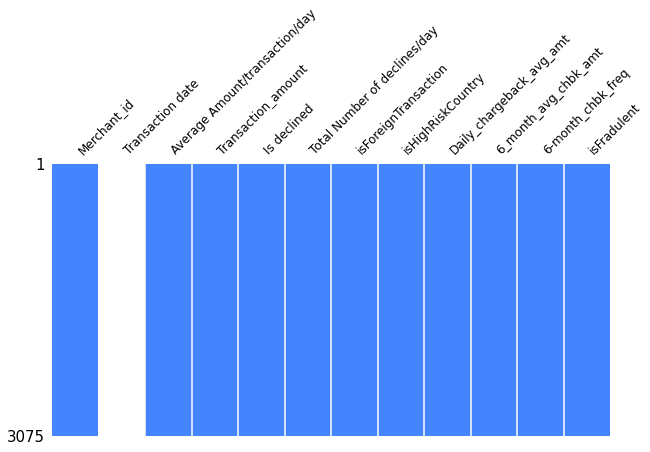

In [8]:
missingno.matrix(creditCard_df,sparkline=False, figsize=(10,5), fontsize=12, color=(0.27, 0.52, 1.0));

La unica variable con missing values es 'Transaction date', de la cual faltan todos los valores. Por tanto se eliminará esta columna del DataFrame

In [9]:
# Eliminamos la columna del dataframe original
creditCard_df.drop('Transaction date', axis = 1, inplace = True)
# Mostramos el dataframe resultante
creditCard_df.head()

,Merchant_id,Average Amount/transaction/day,Transaction_amount,Is declined,Total Number of declines/day,isForeignTransaction,isHighRiskCountry,Daily_chargeback_avg_amt,6_month_avg_chbk_amt,6-month_chbk_freq,isFradulent
0,3160040998,100.0,3000.0,N,5,Y,Y,0,0.0,0,Y
1,3160040998,100.0,4300.0,N,5,Y,Y,0,0.0,0,Y
2,3160041896,185.5,4823.0,Y,5,N,N,0,0.0,0,Y
3,3160141996,185.5,5008.5,Y,8,N,N,0,0.0,0,Y
4,3160241992,500.0,26000.0,N,0,Y,Y,800,677.2,6,Y


## 4. Aplicación de técnicas de detección de anomalías: Isolation Forest

In [10]:
# Función para imprimir la matriz de confusión
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    '''

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

En primer lugar reemplazamos las variables Y y N por 1 y 0 respectivamente

In [11]:
# Change Y and N values to 0 and 1 values
creditCard_df.replace(to_replace = ['Y','N'],value =[1,0],inplace = True)
creditCard_df.head()

,Merchant_id,Average Amount/transaction/day,Transaction_amount,Is declined,Total Number of declines/day,isForeignTransaction,isHighRiskCountry,Daily_chargeback_avg_amt,6_month_avg_chbk_amt,6-month_chbk_freq,isFradulent
0,3160040998,100.0,3000.0,0,5,1,1,0,0.0,0,1
1,3160040998,100.0,4300.0,0,5,1,1,0,0.0,0,1
2,3160041896,185.5,4823.0,1,5,0,0,0,0.0,0,1
3,3160141996,185.5,5008.5,1,8,0,0,0,0.0,0,1
4,3160241992,500.0,26000.0,0,0,1,1,800,677.2,6,1


Separamos el dataset en subconjuntos de entrenamiento y test

In [12]:
cols = list(creditCard_df.columns[1:len(creditCard_df.columns)-1]) # Quitamos el id y la variable y dependiente 
X = creditCard_df[cols].values
Y = creditCard_df['isFradulent']
# Division of dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 3)

A continuación se procede a crear y  entrenar el modelo:

In [19]:
# Creation of the model
if_model = IsolationForest(n_estimators = 100, max_samples = 'auto', contamination = 'auto', max_features = 1)
# Training of the model
if_model.fit(X_train)

IsolationForest(max_features=1)

Realizamos la predicción con el modelo entrenado

In [20]:
yhat_if = if_model.predict(X_test)

Como este modelo retorna el valor -1 para los outliers y valor 1 para los inliers es necesario convertir estos valores a 0 (inlier) y 1 (outlier), que es de la forma que está expresado en Y_test. Por tanto realizamos la conversión:

In [21]:
Yhat_if = [0 if prediction == 1 else 1 for prediction in yhat_if ]

Puesto que teniamos un dataset etiquetado con las muestras fraudulentas, podemos evaluar el resultado de la predicción utilizando la matriz de confusion. A continuación se obtiene la matriz de confusión y las métricas de exactitud, sensibilidad y precision. En la detección de anomalías es interesante la sensibilidad pues proporciona una idea del porcentaje de las anomalias que se estan detectando correctamente. En cuanto a la precision tambien es interesante pues nos da una idea de cuantas de las muestras clasificadas como fraudulentas lo son realmente.

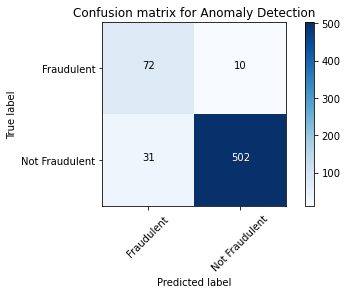

In [22]:
# Creamos e imprimimos la matriz de confusión
conf_matrix_if = confusion_matrix(Yhat_if, Y_test,labels = [1,0]) # Coloco este orden de labels para que los fraudulentos queden como TP y los no fraudulentos como TN (ya que lo que se quiere ver es si son fraudulentos o no) 
plot_confusion_matrix(conf_matrix_if, classes=['Fraudulent','Not Fraudulent'],normalize= False,  title='Confusion matrix for Anomaly Detection')

En la matriz de confusión creada vemos como el algoritmo clasifica correctamente 502 muestras como no fraudulentas y 72 como fraudulentas. En cuanto a los errores, el algoritmo detecta erroneamente 31 muestras como fraudulentas sin serlo, y sin embargo deja sin detectar 10 muestras que eran fraudulentas.

In [23]:
def calculate_metrics(real, predicted):
    print("Accuracy: {:.4f}".format(accuracy_score(real, predicted)))
    print("Precision: {:.4f}".format(precision_score(real, predicted,average = 'weighted')))
    # La sensibilidad es equivalente al recall
    print("Sensibilidad: {:.4f}".format(recall_score(real, predicted,average = 'weighted')))
    print("F1: {:.4f}".format(f1_score(real, predicted,average = 'weighted',labels=np.unique(predicted))))

In [24]:
# Calculamos metricas
calculate_metrics(Y_test,Yhat_if)

Accuracy: 0.9333
Precision: 0.9312
Sensibilidad: 0.9333
F1: 0.9302


Puede verse como se ha obtenido buenos resultados utilizando este algoritmo de detección de anomalias. El buen resultado en la sensibilidad nos muestra como el modelo funciona bien para detectar gran porcentaje de las anomalías.

## 5. Aplicación de técnicas de agrupamiento: K-means

En primer lugar, antes de proceder a la utilización de K-means se procederá a normalizar el dataset. Para ello se utilizará MinMaxScaler que normaliza las variables entre 0 y 1.

In [25]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

En segundo lugar se dividirá los datos en dos conjuntos para realizar el proceso por separado y poder comparar después los resultados entre ellos

In [26]:
X1,X2 = train_test_split(X_scaled, test_size = 0.50)

En tercer lugar, para determinar el numero de cluster que arroja mejores resultados se va a proceder a ejecutar el algoritmo k-means para diferentes numero de clusters. Para evaluarlo se utilizará el Elbow method, el cual da una idea del número de clusters adecuado en base a la suma de las distancias al cuadrado entre los puntos y sus centroides asignados (SEE). Se aplicará para cada uno de los dos subconjuntos hallados en el apartado anterior.

Subconjunto 1:

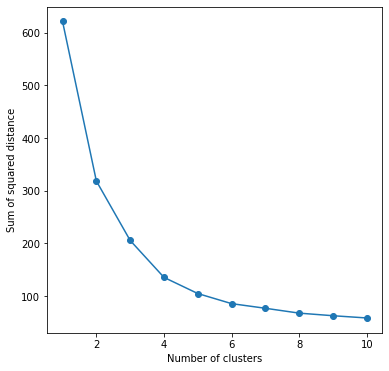

In [27]:
n_clusters = range(1,11)
k_model_sse = []
for n in n_clusters:
    km_model = KMeans(n_clusters = n)
    # Train
    km_model.fit(X1)
    # Evaluation
    k_model_sse.append(km_model.inertia_)

# Plot elbow curve
plt.figure(figsize=(6, 6))
plt.plot(n_clusters, k_model_sse, '-o')
plt.xlabel(r'Number of clusters')
plt.ylabel('Sum of squared distance');

Subconjunto 2:

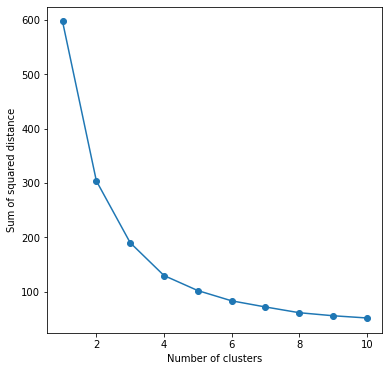

In [28]:
n_clusters = range(1,11)
k_model_sse2 = []
for n in n_clusters:
    km_model = KMeans(n_clusters = n)
    # Train
    km_model.fit(X2)
    # Evaluation
    k_model_sse2.append(km_model.inertia_)

# Plot elbow curve
plt.figure(figsize=(6, 6))
plt.plot(n_clusters, k_model_sse2, '-o')
plt.xlabel(r'Number of clusters')
plt.ylabel('Sum of squared distance');

Nos quedamos con K = 2 para ambos casos

In [29]:
# Entrenamos ambos modelos
# Model creation
km_model1 = KMeans(n_clusters = 2)
km_model2 = KMeans(n_clusters = 2)
# Train
km_model1.fit(X1)
km_model2.fit(X2)

KMeans(n_clusters=2)

A continuación se muestran los centroides:

Subconjunto 1:

In [30]:
centroids1 = km_model1.cluster_centers_
print(centroids1)

[[ 2.44960657e-01  7.58074477e-02  1.18043845e-02  3.50758853e-02
  -1.41553436e-15  3.74700271e-16  4.99548845e-02  3.44504354e-02
   3.81300356e-02]
 [ 2.68783547e-01  1.40649372e-01  3.98860399e-02  1.06552707e-01
   1.00000000e+00  3.24786325e-01  8.12279830e-02  5.88219173e-02
   7.40740741e-02]]


Subconjunto 2:

In [31]:
centroids2 = km_model1.cluster_centers_
print(centroids2)

[[ 2.44960657e-01  7.58074477e-02  1.18043845e-02  3.50758853e-02
  -1.41553436e-15  3.74700271e-16  4.99548845e-02  3.44504354e-02
   3.81300356e-02]
 [ 2.68783547e-01  1.40649372e-01  3.98860399e-02  1.06552707e-01
   1.00000000e+00  3.24786325e-01  8.12279830e-02  5.88219173e-02
   7.40740741e-02]]


A continuación se muestra cuantos de los elementos han entrado en cada cluster:

Subconjunto 1:

In [144]:
labels1 = km_model1.labels_
count_0 = 0
count_1 = 0
for i in range(0,len(labels1)):
    if labels1[i] == 0:
        count_0 +=1
    else:
        count_1 +=1
        

Muestras en primer cluster:

In [145]:
count_0

1158

Muestras en segundo cluster:

In [146]:
count_1

379

Subconjunto 2:

In [155]:
labels2 = km_model2.labels_
count_0 = 0
count_1 = 0
for i in range(0,len(labels2)):
    if labels2[i] == 0:
        count_0 +=1
    else:
        count_1 +=1

Muestras en primer cluster:

In [156]:
count_0

1211

Muestras en segundo cluster:

In [157]:
count_1

327

Se han obtenido los centroides y la agrupación de ambos conjuntos de datos.  Hemos escogido hacer finalmente dos cluster para ver cuantos como los datos se reparten entre sí son fraudulentos o no. Hemos tenido dificultades para poder representar los gráficos y por tanto hemos  indicado cómo se han repartido los puntos en fraudulentos o no. Para ambos casos se ha obtenido que hay una mayor agrupación de datos no fraudulentos


Por último destacar que hemos asumido que los datos fraudulentos tendrían características similares como para que el algoritmo los pudiera clasificar dentro del mismo cluster. Sin embargo, esto podría no ser así, y que las anomalias fueran datos alejados del comportamiento común de los datos por diferentes motivos, y en ese caso habría que utilizar más  numero de clusters para detectar estos grupos. A la vista del gráfico obtenido con el elbow method, un buen valor a evaluar también sería con K=4 clusters.

## 6. Ventajas y desventajas de los modelos empleados

### 6.1 Isolation Forest

El método de Isolation Forest puede ser utilizado tanto de forma supervisada como no supervisada. Está formado por la combinación de múltiples árboles (isolation trees) los cuales se van separando recursivamente creando las ramas del árbol hasta llegar a un nodo terminal. 

Una ventaja es que la selección de los puntos de división se hace de forma aleatoria, por lo que aquellas divisiones distintas al resto quedarán aisladas en pocas divisiones, lo que hace que la profundidad sea menor que con otros métodos utilizados.
Otras ventajas son su diseño sencillo y que es escalable a conjuntos de gran dimensión. 

Un inconveniente cuando se utiliza este método de forma no supervisada es que no hay forma de conocer el valor óptimo a partir del cual se debe considerar que se trata de una anomalía.  El usuario es el que debe determinar el umbral de valores atípicos.


### 6.2 K-means

Como ventajas, se podría destacar que es un método sencillo de implementar, puede tratar con gran número de datos y es fácil de adaptar. Tiene un buen rendimiento si no se involucran muchas dimensiones y si se sabe el nombre de clusters a definir de manera aproximada.
Como desventajas, se podría destacar que a no ser que se tenga información previa de cuantos grupos podría haber, hay que tantear con el valor de k óptimo. Un factor negativo y que ha afectado en esta práctica es que a medida que aumentan las dimensiones de los datos, kmeans se vuelve menos eficaz y es difícil obtener una visualización o conclusión clara de los resultados. Al ser un método de aprendizaje automático no supervisado, no hay una respuesta correcta. Esto hace que la evaluación de los grupos identificados sea un poco subjetiva. Sin embargo, en este caso concreto, sí que se tenían ciertas etiquetas de los datos para realizar las agrupaciones que permiten tener una mejor interpretación de los resultados.


## 7. Conclusiones

Como conclusión podemos destacar que hemos tenido mejor experiencia utilizando el algoritmo de Isolation Forest ya que hemos obtenido unos buenos resultados. Con K-means, debido a las propiedades del algoritmo como la necesidad de conocer el número de clusters ha dificultado encontrar una solución optima.